# **Identifying Key Entities in Recipe Data**


**Business Objective**:
The goal of this assignment is to train a Named Entity Recognition (NER) model using Conditional Random Fields (CRF) to extract key entities from recipe data. The model will classify words into predefined categories such as ingredients, quantities and units, enabling the creation of a structured database of recipes and ingredients that can be used to power advanced features in recipe management systems, dietary tracking apps, or e-commerce platforms.

### **Data Description**
The given data is in JSON format, representing a **structured recipe ingredient list** with **Named Entity Recognition (NER) labels**. Below is a breakdown of the data fields:

```json
[
    {
        "input": "6 Karela Bitter Gourd Pavakkai Salt 1 Onion 3 tablespoon Gram flour besan 2 teaspoons Turmeric powder Haldi Red Chilli Cumin seeds Jeera Coriander Powder Dhania Amchur Dry Mango Sunflower Oil",
        "pos": "quantity ingredient ingredient ingredient ingredient ingredient quantity ingredient quantity unit ingredient ingredient ingredient quantity unit ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient"
    },
    {
      "input": "2-1/2 cups rice cooked 3 tomatoes teaspoons BC Belle Bhat powder 1 teaspoon chickpea lentils 1/2 cumin seeds white urad dal mustard green chilli dry red 2 cashew or peanuts 1-1/2 tablespoon oil asafoetida",
      "pos": "quantity unit ingredient ingredient quantity ingredient unit ingredient ingredient ingredient ingredient quantity unit ingredient ingredient quantity ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient quantity ingredient ingredient ingredient quantity unit ingredient ingredient"
    }
]


| **Key**  | **Description**  |
|----------|-----------------|
| `input`  | Contains a raw ingredient list from a recipe. |
| `pos`    | Represents the corresponding part-of-speech (POS) tags or NER labels, identifying quantities, ingredients, and units. |


## **1** Import libraries

#### **1.1** Installation of sklearn-crfsuite

sklearn-crfsuite is a Python wrapper for CRFsuite, a fast and efficient implementation of Conditional Random Fields (CRFs). It is designed to integrate seamlessly with scikit-learn for structured prediction tasks such as Named Entity Recognition (NER), Part-of-Speech (POS) tagging, and chunking.

In [95]:
# installation of sklearn_crfsuite
!pip install sklearn_crfsuite==0.5.0

#### **1.2** Import necessary libraries

In [96]:
# Import warnings
import warnings
warnings.filterwarnings('ignore')

In [97]:
# Import necessary libraries
import json  # For handling JSON data
import pandas as pd  # For data manipulation and analysis
import re  # For regular expressions (useful for text preprocessing)
import matplotlib.pyplot as plt  # For visualisation
import seaborn as sns  # For advanced data visualisation
import sklearn_crfsuite  # CRF (Conditional Random Fields) implementation for sequence modeling
import numpy as np  # For numerical computations
# Saving and loading machine learning models
import joblib
import random
import spacy
from IPython.display import display, Markdown # For displaying well-formatted output

from fractions import Fraction  # For handling fractional values in numerical data
# Importing tools for feature engineering and model training
from collections import Counter  # For counting occurrences of elements in a list
from sklearn.model_selection import train_test_split  # For splitting dataset into train and test sets
from sklearn_crfsuite import metrics  # For evaluating CRF models
from sklearn_crfsuite.metrics import flat_classification_report
from sklearn.utils.class_weight import compute_class_weight
from collections import Counter
from sklearn.metrics import confusion_matrix

In [98]:
# Ensure pandas displays full content
pd.set_option('display.max_colwidth', None)
pd.set_option('display.expand_frame_repr', False)

## **2** Data Ingestion and Preparation <font color = red>[25 marks]</font> <br>

#### **2.1** *Read Recipe Data from Dataframe and prepare the data for analysis* <font color = red>[12 marks]</font> <br>
Read the data from JSON file, print first five rows and describe the dataframe

In [99]:
from google.colab import files
uploaded = files.upload()

import pandas as pd
import json

df = pd.read_json('ingredient_and_quantity.json')

# Optional: Display the DataFrame

df.head()

Saving ingredient_and_quantity.json to ingredient_and_quantity (1).json


,input,pos
0,6 Karela Bitter Gourd Pavakkai Salt 1 Onion 3 tablespoon Gram flour besan 2 teaspoons Turmeric powder Haldi Red Chilli Cumin seeds Jeera Coriander Powder Dhania Amchur Dry Mango Sunflower Oil,quantity ingredient ingredient ingredient ingredient ingredient quantity ingredient quantity unit ingredient ingredient ingredient quantity unit ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient
1,2-1/2 cups rice cooked 3 tomatoes teaspoons BC Belle Bhat powder 1 teaspoon chickpea lentils 1/2 cumin seeds white urad dal mustard green chilli dry red 2 cashew or peanuts 1-1/2 tablespoon oil asafoetida,quantity unit ingredient ingredient quantity ingredient unit ingredient ingredient ingredient ingredient quantity unit ingredient ingredient quantity ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient quantity ingredient ingredient ingredient quantity unit ingredient ingredient
2,1-1/2 cups Rice Vermicelli Noodles Thin 1 Onion sliced 1/2 cup Carrots Gajjar chopped 1/3 Green peas Matar 2 Chillies 1/4 teaspoon Asafoetida hing Mustard seeds White Urad Dal Split Ghee sprig Curry leaves Salt Lemon juice,quantity unit ingredient ingredient ingredient ingredient quantity ingredient ingredient quantity unit ingredient ingredient ingredient quantity ingredient ingredient ingredient quantity ingredient quantity unit ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient unit ingredient ingredient ingredient ingredient ingredient
3,500 grams Chicken 2 Onion chopped 1 Tomato 4 Green Chillies slit inch Ginger finely 6 cloves Garlic 1/2 teaspoon Turmeric powder Haldi Garam masala tablespoon Sesame Gingelly Oil 1/4 Methi Seeds Fenugreek Coriander Dhania Dry Red Fennel seeds Saunf cups Sorrel Leaves Gongura picked and,quantity unit ingredient quantity ingredient ingredient quantity ingredient quantity ingredient ingredient ingredient unit ingredient ingredient quantity unit ingredient quantity unit ingredient ingredient ingredient ingredient ingredient unit ingredient ingredient ingredient quantity ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient unit ingredient ingredient ingredient ingredient ingredient
4,1 tablespoon chana dal white urad 2 red chillies coriander seeds 3 inches ginger onion tomato Teaspoon mustard asafoetida sprig curry,quantity unit ingredient ingredient ingredient ingredient quantity ingredient ingredient ingredient ingredient quantity unit ingredient ingredient ingredient unit ingredient ingredient unit ingredient


In [8]:
df.describe()

,input,pos
count,285,285
unique,285,284
top,1/2 cup Bajra Flour Jowar Whole Wheat 2 cups Methi Leaves inch Ginger 3 Green Chillies 1 tablespoon Sesame seeds teaspoons Red Chilli powder Turmeric 1/4 teaspoon Asafoetida 5 tablespoons Curd Sugar Sunflower Oil,quantity ingredient ingredient ingredient ingredient quantity unit ingredient quantity unit ingredient ingredient ingredient quantity ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient
freq,1,2


##### **2.1.1** **Define a *load_json_dataframe* function** <font color = red>[7 marks]</font> <br>

Define a function that takes path of the ingredient_and_quantity.json file and reads it, convert it into dataframe - df and return it.

In [100]:
# define a function to load json file to a dataframe

import pandas as pd
import json

def read_ingredients_json(filepath):
    """
    Reads a JSON file containing ingredient and quantity data,
    converts it to a pandas DataFrame, and returns it.

    Parameters:
        filepath (str): The path to the ingredient_and_quantity.json file.

    Returns:
        pd.DataFrame: A DataFrame containing the JSON data.
    """
    with open(filepath, 'r') as file:
        data = json.load(file)

    # Convert to DataFrame
    df = pd.json_normalize(data)
    return df


##### **2.1.2** **Execute the *load_json_dataframe* function** <font color = red>[2 marks]</font> <br>

In [101]:
# read the json file by giving the file path and create a dataframe

filepath = 'ingredient_and_quantity.json'
df = read_ingredients_json(filepath)


##### **2.1.3** **Describe the dataframe** <font color = red>[3 marks]</font> <br>

Print first five rows of dataframe along with dimensions. Display the information of dataframe

In [102]:
# display first five rows of the dataframe - df

df.head()


,input,pos
0,6 Karela Bitter Gourd Pavakkai Salt 1 Onion 3 tablespoon Gram flour besan 2 teaspoons Turmeric powder Haldi Red Chilli Cumin seeds Jeera Coriander Powder Dhania Amchur Dry Mango Sunflower Oil,quantity ingredient ingredient ingredient ingredient ingredient quantity ingredient quantity unit ingredient ingredient ingredient quantity unit ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient
1,2-1/2 cups rice cooked 3 tomatoes teaspoons BC Belle Bhat powder 1 teaspoon chickpea lentils 1/2 cumin seeds white urad dal mustard green chilli dry red 2 cashew or peanuts 1-1/2 tablespoon oil asafoetida,quantity unit ingredient ingredient quantity ingredient unit ingredient ingredient ingredient ingredient quantity unit ingredient ingredient quantity ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient quantity ingredient ingredient ingredient quantity unit ingredient ingredient
2,1-1/2 cups Rice Vermicelli Noodles Thin 1 Onion sliced 1/2 cup Carrots Gajjar chopped 1/3 Green peas Matar 2 Chillies 1/4 teaspoon Asafoetida hing Mustard seeds White Urad Dal Split Ghee sprig Curry leaves Salt Lemon juice,quantity unit ingredient ingredient ingredient ingredient quantity ingredient ingredient quantity unit ingredient ingredient ingredient quantity ingredient ingredient ingredient quantity ingredient quantity unit ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient unit ingredient ingredient ingredient ingredient ingredient
3,500 grams Chicken 2 Onion chopped 1 Tomato 4 Green Chillies slit inch Ginger finely 6 cloves Garlic 1/2 teaspoon Turmeric powder Haldi Garam masala tablespoon Sesame Gingelly Oil 1/4 Methi Seeds Fenugreek Coriander Dhania Dry Red Fennel seeds Saunf cups Sorrel Leaves Gongura picked and,quantity unit ingredient quantity ingredient ingredient quantity ingredient quantity ingredient ingredient ingredient unit ingredient ingredient quantity unit ingredient quantity unit ingredient ingredient ingredient ingredient ingredient unit ingredient ingredient ingredient quantity ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient unit ingredient ingredient ingredient ingredient ingredient
4,1 tablespoon chana dal white urad 2 red chillies coriander seeds 3 inches ginger onion tomato Teaspoon mustard asafoetida sprig curry,quantity unit ingredient ingredient ingredient ingredient quantity ingredient ingredient ingredient ingredient quantity unit ingredient ingredient ingredient unit ingredient ingredient unit ingredient


In [103]:
# print the dimensions of dataframe - df

print("DataFrame dimensions:", df.shape)


DataFrame dimensions: (285, 2)


In [104]:
# print the information of the dataframe

df.info()



<class 'pandas.core.frame.DataFrame'>
RangeIndex: 285 entries, 0 to 284
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   input   285 non-null    object
 1   pos     285 non-null    object
dtypes: object(2)
memory usage: 4.6+ KB


#### **2.2** *Recipe Data Manipulation* <font color = red>[13 marks]</font> <br>
Create derived metrics in dataframe and provide insights of the dataframe

##### **2.2.1** **Create input_tokens and pos_tokens columns by splitting the input and pos from the dataframe** <font color = red>[3 marks]</font> <br>
Split the input and pos into input_tokens and pos_tokens in the dataframe and display it in the dataframe

In [105]:
# split the input and pos into input_tokens and pos_tokens in the dataframe

# Tokenize input
# Tokenize POS


# Tokenize the 'input' column
df['input_tokens'] = df['input'].apply(lambda x: x.split() if isinstance(x, str) else [])

# Tokenize the 'pos' column
df['pos_tokens'] = df['pos'].apply(lambda x: x.split() if isinstance(x, str) else [])



In [106]:
# display first five rows of the dataframe - df

df[['input', 'input_tokens', 'pos', 'pos_tokens']].head()


,input,input_tokens,pos,pos_tokens
0,6 Karela Bitter Gourd Pavakkai Salt 1 Onion 3 tablespoon Gram flour besan 2 teaspoons Turmeric powder Haldi Red Chilli Cumin seeds Jeera Coriander Powder Dhania Amchur Dry Mango Sunflower Oil,"[6, Karela, Bitter, Gourd, Pavakkai, Salt, 1, Onion, 3, tablespoon, Gram, flour, besan, 2, teaspoons, Turmeric, powder, Haldi, Red, Chilli, Cumin, seeds, Jeera, Coriander, Powder, Dhania, Amchur, Dry, Mango, Sunflower, Oil]",quantity ingredient ingredient ingredient ingredient ingredient quantity ingredient quantity unit ingredient ingredient ingredient quantity unit ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient,"[quantity, ingredient, ingredient, ingredient, ingredient, ingredient, quantity, ingredient, quantity, unit, ingredient, ingredient, ingredient, quantity, unit, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient]"
1,2-1/2 cups rice cooked 3 tomatoes teaspoons BC Belle Bhat powder 1 teaspoon chickpea lentils 1/2 cumin seeds white urad dal mustard green chilli dry red 2 cashew or peanuts 1-1/2 tablespoon oil asafoetida,"[2-1/2, cups, rice, cooked, 3, tomatoes, teaspoons, BC, Belle, Bhat, powder, 1, teaspoon, chickpea, lentils, 1/2, cumin, seeds, white, urad, dal, mustard, green, chilli, dry, red, 2, cashew, or, peanuts, 1-1/2, tablespoon, oil, asafoetida]",quantity unit ingredient ingredient quantity ingredient unit ingredient ingredient ingredient ingredient quantity unit ingredient ingredient quantity ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient quantity ingredient ingredient ingredient quantity unit ingredient ingredient,"[quantity, unit, ingredient, ingredient, quantity, ingredient, unit, ingredient, ingredient, ingredient, ingredient, quantity, unit, ingredient, ingredient, quantity, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, quantity, ingredient, ingredient, ingredient, quantity, unit, ingredient, ingredient]"
2,1-1/2 cups Rice Vermicelli Noodles Thin 1 Onion sliced 1/2 cup Carrots Gajjar chopped 1/3 Green peas Matar 2 Chillies 1/4 teaspoon Asafoetida hing Mustard seeds White Urad Dal Split Ghee sprig Curry leaves Salt Lemon juice,"[1-1/2, cups, Rice, Vermicelli, Noodles, Thin, 1, Onion, sliced, 1/2, cup, Carrots, Gajjar, chopped, 1/3, Green, peas, Matar, 2, Chillies, 1/4, teaspoon, Asafoetida, hing, Mustard, seeds, White, Urad, Dal, Split, Ghee, sprig, Curry, leaves, Salt, Lemon, juice]",quantity unit ingredient ingredient ingredient ingredient quantity ingredient ingredient quantity unit ingredient ingredient ingredient quantity ingredient ingredient ingredient quantity ingredient quantity unit ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient unit ingredient ingredient ingredient ingredient ingredient,"[quantity, unit, ingredient, ingredient, ingredient, ingredient, quantity, ingredient, ingredient, quantity, unit, ingredient, ingredient, ingredient, quantity, ingredient, ingredient, ingredient, quantity, ingredient, quantity, unit, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, unit, ingredient, ingredient, ingredient, ingredient, ingredient]"
3,500 grams Chicken 2 Onion chopped 1 Tomato 4 Green Chillies slit inch Ginger finely 6 cloves Garlic 1/2 teaspoon Turmeric powder Haldi Garam masala tablespoon Sesame Gingelly Oil 1/4 Methi Seeds Fenugreek Coriander Dhania Dry Red Fennel seeds Saunf cups Sorrel Leaves Gongura picked and,"[500, grams, Chicken, 2, Onion, chopped, 1, Tomato, 4, Green, Chillies, slit, inch, Ginger, finely, 6, cloves, Garlic, 1/2, teaspoon, Turmeric, pow

##### **2.2.2** **Provide the length for input_tokens and pos_tokens and validate their length** <font color = red>[2 marks]</font> <br>

Create input_length and pos_length columns in the dataframe and validate both the lengths. Check for the rows that are unequal in input and pos length


In [107]:
# create input_length and pos_length columns for the input_tokens and pos-tokens

df['input_length'] = df['input_tokens'].apply(len)
df['pos_length'] = df['pos_tokens'].apply(len)

# Check the first few rows to verify
df[['input', 'input_tokens', 'input_length', 'pos', 'pos_tokens', 'pos_length']].head()


,input,input_tokens,input_length,pos,pos_tokens,pos_length
0,6 Karela Bitter Gourd Pavakkai Salt 1 Onion 3 tablespoon Gram flour besan 2 teaspoons Turmeric powder Haldi Red Chilli Cumin seeds Jeera Coriander Powder Dhania Amchur Dry Mango Sunflower Oil,"[6, Karela, Bitter, Gourd, Pavakkai, Salt, 1, Onion, 3, tablespoon, Gram, flour, besan, 2, teaspoons, Turmeric, powder, Haldi, Red, Chilli, Cumin, seeds, Jeera, Coriander, Powder, Dhania, Amchur, Dry, Mango, Sunflower, Oil]",31,quantity ingredient ingredient ingredient ingredient ingredient quantity ingredient quantity unit ingredient ingredient ingredient quantity unit ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient,"[quantity, ingredient, ingredient, ingredient, ingredient, ingredient, quantity, ingredient, quantity, unit, ingredient, ingredient, ingredient, quantity, unit, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient]",31
1,2-1/2 cups rice cooked 3 tomatoes teaspoons BC Belle Bhat powder 1 teaspoon chickpea lentils 1/2 cumin seeds white urad dal mustard green chilli dry red 2 cashew or peanuts 1-1/2 tablespoon oil asafoetida,"[2-1/2, cups, rice, cooked, 3, tomatoes, teaspoons, BC, Belle, Bhat, powder, 1, teaspoon, chickpea, lentils, 1/2, cumin, seeds, white, urad, dal, mustard, green, chilli, dry, red, 2, cashew, or, peanuts, 1-1/2, tablespoon, oil, asafoetida]",34,quantity unit ingredient ingredient quantity ingredient unit ingredient ingredient ingredient ingredient quantity unit ingredient ingredient quantity ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient quantity ingredient ingredient ingredient quantity unit ingredient ingredient,"[quantity, unit, ingredient, ingredient, quantity, ingredient, unit, ingredient, ingredient, ingredient, ingredient, quantity, unit, ingredient, ingredient, quantity, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, quantity, ingredient, ingredient, ingredient, quantity, unit, ingredient, ingredient]",34
2,1-1/2 cups Rice Vermicelli Noodles Thin 1 Onion sliced 1/2 cup Carrots Gajjar chopped 1/3 Green peas Matar 2 Chillies 1/4 teaspoon Asafoetida hing Mustard seeds White Urad Dal Split Ghee sprig Curry leaves Salt Lemon juice,"[1-1/2, cups, Rice, Vermicelli, Noodles, Thin, 1, Onion, sliced, 1/2, cup, Carrots, Gajjar, chopped, 1/3, Green, peas, Matar, 2, Chillies, 1/4, teaspoon, Asafoetida, hing, Mustard, seeds, White, Urad, Dal, Split, Ghee, sprig, Curry, leaves, Salt, Lemon, juice]",37,quantity unit ingredient ingredient ingredient ingredient quantity ingredient ingredient quantity unit ingredient ingredient ingredient quantity ingredient ingredient ingredient quantity ingredient quantity unit ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient unit ingredient ingredient ingredient ingredient ingredient,"[quantity, unit, ingredient, ingredient, ingredient, ingredient, quantity, ingredient, ingredient, quantity, unit, ingredient, ingredient, ingredient, quantity, ingredient, ingredient, ingredient, quantity, ingredient, quantity, unit, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, unit, ingredient, ingredient, ingredient, ingredient, ingredient]",37
3,500 grams Chicken 2 Onion chopped 1 Tomato 4 Green Chillies slit inch Ginger finely 6 cloves Garlic 1/2 teaspoon Turmeric powder Haldi Garam masala tablespoon Sesame Gingelly Oil 1/4 Methi Seeds Fenugreek Coriander Dhania Dry Red Fennel seeds Saunf cups Sorrel Leaves Gongura picked and,"[500, grams, Chicken, 2, Onion, chopped, 1, Tomato, 4, Green, Chillies, slit, inch, Ginger, finely, 6, cl

In [108]:
# check for the equality of input_length and pos_length in the dataframe

# Check if input_length is equal to pos_length and created a new column 'length_equal'
df['length_equal'] = df['input_length'] == df['pos_length']

# Displayed the DataFrame with the new column created length_equal
df[['input', 'input_length', 'pos_length', 'length_equal']].head()

,input,input_length,pos_length,length_equal
0,6 Karela Bitter Gourd Pavakkai Salt 1 Onion 3 tablespoon Gram flour besan 2 teaspoons Turmeric powder Haldi Red Chilli Cumin seeds Jeera Coriander Powder Dhania Amchur Dry Mango Sunflower Oil,31,31,True
1,2-1/2 cups rice cooked 3 tomatoes teaspoons BC Belle Bhat powder 1 teaspoon chickpea lentils 1/2 cumin seeds white urad dal mustard green chilli dry red 2 cashew or peanuts 1-1/2 tablespoon oil asafoetida,34,34,True
2,1-1/2 cups Rice Vermicelli Noodles Thin 1 Onion sliced 1/2 cup Carrots Gajjar chopped 1/3 Green peas Matar 2 Chillies 1/4 teaspoon Asafoetida hing Mustard seeds White Urad Dal Split Ghee sprig Curry leaves Salt Lemon juice,37,37,True
3,500 grams Chicken 2 Onion chopped 1 Tomato 4 Green Chillies slit inch Ginger finely 6 cloves Garlic 1/2 teaspoon Turmeric powder Haldi Garam masala tablespoon Sesame Gingelly Oil 1/4 Methi Seeds Fenugreek Coriander Dhania Dry Red Fennel seeds Saunf cups Sorrel Leaves Gongura picked and,46,46,True
4,1 tablespoon chana dal white urad 2 red chillies coriander seeds 3 inches ginger onion tomato Teaspoon mustard asafoetida sprig curry,21,21,True


##### **2.2.3** **Define a unique_labels function and validate the labels in pos_tokens** <font color = red>[2 marks]</font> <br>

Define a unique_labels function which checks for all the unique pos labels in the recipe & execute it.


In [109]:
# Define a unique_labels function to checks for all the unique pos labels in the recipe & print it

def unique_labels(df):
    """
    Extract all unique POS labels from the 'pos_tokens' column of the DataFrame.

    Parameters:
    df (pd.DataFrame): The dataframe containing a 'pos_tokens' column (list of POS tags)

    Returns:
    set: A set of unique POS labels
    """
    all_labels = set()
    for label_list in df['pos_tokens']:
        all_labels.update(label_list)
    return all_labels

# Call the function and print results
unique_labels = unique_labels(df)
print(unique_labels)


{'unit', 'ingredient', 'quantity'}


##### **2.2.3** **Provide the insights seen in the recipe data after validation** <font color = red>[1 marks]</font> <br>

Provide the indexes that requires cleaning and formatting in the dataframe

<font color = red>[write your answer]</font> <br>

1. Rows with missing (NaN or empty) values.
2. Rows where input_tokens and pos_tokens lengths do not match.
3. Rows where input_tokens or pos_tokens have unexpected formats (e.g., not lists of strings).

##### **2.2.4** **Drop the rows that have invalid data provided in previous cell** <font color = red> [2 marks]</font> <br>

In [110]:
# drop the irrelevant recipe data

def clean_dataframe(df):
    # Drop rows with missing or NaN values in input_tokens or pos_tokens
    df = df.dropna(subset=['input_tokens', 'pos_tokens'])

    # Drop rows where input_tokens or pos_tokens are not lists
    df = df[df['input_tokens'].apply(lambda x: isinstance(x, list))]
    df = df[df['pos_tokens'].apply(lambda x: isinstance(x, list))]

    # Drop rows where the lengths of input_tokens and pos_tokens do not match
    df = df[df['input_tokens'].str.len() == df['pos_tokens'].str.len()]

    # Drop rows where either token list is empty
    df = df[df['input_tokens'].str.len() > 0]
    df = df[df['pos_tokens'].str.len() > 0]

    return df.reset_index(drop=True)


clean_dataframe(df)

# Print final shape
print("Cleaned DataFrame shape:", df.shape)


Cleaned DataFrame shape: (285, 7)


##### **2.2.5** **Update the input_length & pos_length in dataframe**<font color = red> [2 marks]</font> <br>

In [111]:
# update the input and pos length in input_length and pos_length

# Recalculate input_length and pos_length based on the updated 'input_tokens' and 'pos_tokens'
df['input_length'] = df['input_tokens'].apply(len)
df['pos_length'] = df['pos_tokens'].apply(len)

# Check the updated DataFrame to verify
df[['input', 'input_tokens', 'input_length', 'pos', 'pos_tokens', 'pos_length']].head()

,input,input_tokens,input_length,pos,pos_tokens,pos_length
0,6 Karela Bitter Gourd Pavakkai Salt 1 Onion 3 tablespoon Gram flour besan 2 teaspoons Turmeric powder Haldi Red Chilli Cumin seeds Jeera Coriander Powder Dhania Amchur Dry Mango Sunflower Oil,"[6, Karela, Bitter, Gourd, Pavakkai, Salt, 1, Onion, 3, tablespoon, Gram, flour, besan, 2, teaspoons, Turmeric, powder, Haldi, Red, Chilli, Cumin, seeds, Jeera, Coriander, Powder, Dhania, Amchur, Dry, Mango, Sunflower, Oil]",31,quantity ingredient ingredient ingredient ingredient ingredient quantity ingredient quantity unit ingredient ingredient ingredient quantity unit ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient,"[quantity, ingredient, ingredient, ingredient, ingredient, ingredient, quantity, ingredient, quantity, unit, ingredient, ingredient, ingredient, quantity, unit, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient]",31
1,2-1/2 cups rice cooked 3 tomatoes teaspoons BC Belle Bhat powder 1 teaspoon chickpea lentils 1/2 cumin seeds white urad dal mustard green chilli dry red 2 cashew or peanuts 1-1/2 tablespoon oil asafoetida,"[2-1/2, cups, rice, cooked, 3, tomatoes, teaspoons, BC, Belle, Bhat, powder, 1, teaspoon, chickpea, lentils, 1/2, cumin, seeds, white, urad, dal, mustard, green, chilli, dry, red, 2, cashew, or, peanuts, 1-1/2, tablespoon, oil, asafoetida]",34,quantity unit ingredient ingredient quantity ingredient unit ingredient ingredient ingredient ingredient quantity unit ingredient ingredient quantity ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient quantity ingredient ingredient ingredient quantity unit ingredient ingredient,"[quantity, unit, ingredient, ingredient, quantity, ingredient, unit, ingredient, ingredient, ingredient, ingredient, quantity, unit, ingredient, ingredient, quantity, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, quantity, ingredient, ingredient, ingredient, quantity, unit, ingredient, ingredient]",34
2,1-1/2 cups Rice Vermicelli Noodles Thin 1 Onion sliced 1/2 cup Carrots Gajjar chopped 1/3 Green peas Matar 2 Chillies 1/4 teaspoon Asafoetida hing Mustard seeds White Urad Dal Split Ghee sprig Curry leaves Salt Lemon juice,"[1-1/2, cups, Rice, Vermicelli, Noodles, Thin, 1, Onion, sliced, 1/2, cup, Carrots, Gajjar, chopped, 1/3, Green, peas, Matar, 2, Chillies, 1/4, teaspoon, Asafoetida, hing, Mustard, seeds, White, Urad, Dal, Split, Ghee, sprig, Curry, leaves, Salt, Lemon, juice]",37,quantity unit ingredient ingredient ingredient ingredient quantity ingredient ingredient quantity unit ingredient ingredient ingredient quantity ingredient ingredient ingredient quantity ingredient quantity unit ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient unit ingredient ingredient ingredient ingredient ingredient,"[quantity, unit, ingredient, ingredient, ingredient, ingredient, quantity, ingredient, ingredient, quantity, unit, ingredient, ingredient, ingredient, quantity, ingredient, ingredient, ingredient, quantity, ingredient, quantity, unit, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, unit, ingredient, ingredient, ingredient, ingredient, ingredient]",37
3,500 grams Chicken 2 Onion chopped 1 Tomato 4 Green Chillies slit inch Ginger finely 6 cloves Garlic 1/2 teaspoon Turmeric powder Haldi Garam masala tablespoon Sesame Gingelly Oil 1/4 Methi Seeds Fenugreek Coriander Dhania Dry Red Fennel seeds Saunf cups Sorrel Leaves Gongura picked and,"[500, grams, Chicken, 2, Onion, chopped, 1, Tomato, 4, Green, Chillies, slit, inch, Ginger, finely, 6, cl

##### **2.2.6** **Validate the input_length and pos_length by checking unequal rows** <font color = red> [1 marks]</font> <br>

In [112]:
# validate the input length and pos length as input_length and pos_length

def validate_lengths_and_count(df):

    # Create a new column 'length_valid' that is True if input_length == pos_length, False otherwise
    df['length_valid'] = df['input_length'] == df['pos_length']

    # Get the count of rows where lengths do not match
    mismatched_rows_count = df[~df['length_valid']].shape[0]

    # Print the count of mismatched rows
    print(f"Count of rows with mismatched lengths (input_length != pos_length): {mismatched_rows_count}")

    return df


df_validated = validate_lengths_and_count(df)

# Optionally, you can check the DataFrame with the new 'length_valid' column
df_validated.head()

Count of rows with mismatched lengths (input_length != pos_length): 5


,input,pos,input_tokens,pos_tokens,input_length,pos_length,length_equal,length_valid
0,6 Karela Bitter Gourd Pavakkai Salt 1 Onion 3 tablespoon Gram flour besan 2 teaspoons Turmeric powder Haldi Red Chilli Cumin seeds Jeera Coriander Powder Dhania Amchur Dry Mango Sunflower Oil,quantity ingredient ingredient ingredient ingredient ingredient quantity ingredient quantity unit ingredient ingredient ingredient quantity unit ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient,"[6, Karela, Bitter, Gourd, Pavakkai, Salt, 1, Onion, 3, tablespoon, Gram, flour, besan, 2, teaspoons, Turmeric, powder, Haldi, Red, Chilli, Cumin, seeds, Jeera, Coriander, Powder, Dhania, Amchur, Dry, Mango, Sunflower, Oil]","[quantity, ingredient, ingredient, ingredient, ingredient, ingredient, quantity, ingredient, quantity, unit, ingredient, ingredient, ingredient, quantity, unit, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient]",31,31,True,True
1,2-1/2 cups rice cooked 3 tomatoes teaspoons BC Belle Bhat powder 1 teaspoon chickpea lentils 1/2 cumin seeds white urad dal mustard green chilli dry red 2 cashew or peanuts 1-1/2 tablespoon oil asafoetida,quantity unit ingredient ingredient quantity ingredient unit ingredient ingredient ingredient ingredient quantity unit ingredient ingredient quantity ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient quantity ingredient ingredient ingredient quantity unit ingredient ingredient,"[2-1/2, cups, rice, cooked, 3, tomatoes, teaspoons, BC, Belle, Bhat, powder, 1, teaspoon, chickpea, lentils, 1/2, cumin, seeds, white, urad, dal, mustard, green, chilli, dry, red, 2, cashew, or, peanuts, 1-1/2, tablespoon, oil, asafoetida]","[quantity, unit, ingredient, ingredient, quantity, ingredient, unit, ingredient, ingredient, ingredient, ingredient, quantity, unit, ingredient, ingredient, quantity, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, quantity, ingredient, ingredient, ingredient, quantity, unit, ingredient, ingredient]",34,34,True,True
2,1-1/2 cups Rice Vermicelli Noodles Thin 1 Onion sliced 1/2 cup Carrots Gajjar chopped 1/3 Green peas Matar 2 Chillies 1/4 teaspoon Asafoetida hing Mustard seeds White Urad Dal Split Ghee sprig Curry leaves Salt Lemon juice,quantity unit ingredient ingredient ingredient ingredient quantity ingredient ingredient quantity unit ingredient ingredient ingredient quantity ingredient ingredient ingredient quantity ingredient quantity unit ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient unit ingredient ingredient ingredient ingredient ingredient,"[1-1/2, cups, Rice, Vermicelli, Noodles, Thin, 1, Onion, sliced, 1/2, cup, Carrots, Gajjar, chopped, 1/3, Green, peas, Matar, 2, Chillies, 1/4, teaspoon, Asafoetida, hing, Mustard, seeds, White, Urad, Dal, Split, Ghee, sprig, Curry, leaves, Salt, Lemon, juice]","[quantity, unit, ingredient, ingredient, ingredient, ingredient, quantity, ingredient, ingredient, quantity, unit, ingredient, ingredient, ingredient, quantity, ingredient, ingredient, ingredient, quantity, ingredient, quantity, unit, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, unit, ingredient, ingredient, ingredient, ingredient, ingredient]",37,37,True,True
3,500 grams Chicken 2 Onion chopped 1 Tomato 4 Green Chillies slit inch Ginger finely 6 cloves Garlic 1/2 teaspoon Turmeric powder Haldi Garam masala tablespoon Sesame Gingelly Oil 1/4 Methi Seeds Fenugreek Coriander Dhania Dry Red Fennel seeds Saunf cups Sorrel Leaves Gongura picked and,quantity unit ingredient quantity ingredient ingre

## **3** Train Validation Split (70 train - 30 val) <font color = red>[6 marks]</font> <br>

#### **3.1** *Perform train and validation split ratio* <font color = red>[6 marks]</font> <br>
Split the dataset with the help of input_tokens and pos_tokens and make a ratio of 70:30 split for training and validation datasets.

###### **3.1.1** **Split the dataset into train_df and val_df into 70:30 ratio** <font color = red> [1 marks]</font> <br>

In [113]:
# split the dataset into training and validation sets

from sklearn.model_selection import train_test_split

# Split the dataset into train_df and val_df with a 70:30 ratio
train_df, val_df = train_test_split(df_validated, test_size=0.3, random_state=42)

# Check the shapes of the resulting DataFrames
print(f"Training DataFrame shape: {train_df.shape}")
print(f"Validation DataFrame shape: {val_df.shape}")


Training DataFrame shape: (199, 8)
Validation DataFrame shape: (86, 8)


###### **3.1.2** **Print the first five rows of train_df and val_df** <font color = red> [1 marks]</font> <br>

In [114]:
# print the first five rows of train_df

print(train_df.head())

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                input                                                                                                                                                                                                                                                                                                                                                                                                                                                   

In [115]:
# print the first five rows of the val_df

print(val_df.head())

                                                                                                                                                                                                                                                                                                                                           input                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                           pos                                                                                                                                          

###### **3.1.3** **Extract the dataset into train_df and val_df into X_train, X_val, y_train and y_val and display their length** <font color = red> [2 marks]</font> <br>

Extract X_train, X_val, y_train and y_val by extracting the list of input_tokens and pos_tokens from train_df and val_df and also display their length

In [116]:
# extract the training and validation sets by taking input_tokens and pos_tokens

X_train = train_df['input_tokens'].tolist()
y_train = train_df['pos_tokens'].tolist()

# Extract input_tokens and pos_tokens from val_df
X_val = val_df['input_tokens'].tolist()
y_val = val_df['pos_tokens'].tolist()

# Display their lengths
print("Length of X_train:", len(X_train))
print("Length of y_train:", len(y_train))
print("Length of X_val:", len(X_val))
print("Length of y_val:", len(y_val))

Length of X_train: 199
Length of y_train: 199
Length of X_val: 86
Length of y_val: 86


In [117]:
# validate the shape of training and validation samples

# Check for mismatches in training data
mismatched_train = [(i, len(X_train[i]), len(y_train[i]))
                    for i in range(len(X_train))
                    if len(X_train[i]) != len(y_train[i])]

# Check for mismatches in validation data
mismatched_val = [(i, len(X_val[i]), len(y_val[i]))
                  for i in range(len(X_val))
                  if len(X_val[i]) != len(y_val[i])]

# Display results
print("\nMismatched entries in training data:", len(mismatched_train))
if mismatched_train:
    print("Examples from training:", mismatched_train[:3])

print("\nMismatched entries in validation data:", len(mismatched_val))
if mismatched_val:
    print("Examples from validation:", mismatched_val[:3])



Mismatched entries in training data: 3
Examples from training: [(82, 18, 17), (88, 37, 36), (160, 15, 14)]

Mismatched entries in validation data: 2
Examples from validation: [(34, 38, 37), (76, 54, 53)]


###### **3.1.4** **Display the number of unique labels present in y_train** <font color = red> [2 marks]</font> <br>

In [118]:
# Display the number of unique labels present in y_train

y_train = train_df['pos_tokens']

# Get the number of unique labels in y_train
unique_labels = y_train.apply(lambda x: len(set(x))).sum()  # Counts unique tokens per row (if needed)
num_unique_labels = len(set([item for sublist in y_train for item in sublist]))

# Display the number of unique labels
print(f"Number of unique labels in y_train: {num_unique_labels}")


Number of unique labels in y_train: 3


## **4** Exploratory Recipe Data Analysis on Training Dataset <font color = red>[16 marks]</font> <br>

#### **4.1** *Flatten the lists for input_tokens & pos_tokens* <font color = red>[2 marks]</font> <br>

Define a function **flatten_list** for flattening the structure for input_tokens and pos_tokens. The input parameter passed to this function is a nested list.

Initialise the dataset_name with a value ***'Training'***




In [119]:
# flatten the list for nested_list (input_tokens, pos_tokens)


# Flatten input_tokens
flattened_input_tokens = [token for sublist in train_df['input_tokens'] for token in sublist]

# Flatten pos_tokens
flattened_pos_tokens = [token for sublist in train_df['pos_tokens'] for token in sublist]

# Print sample and length for verification
print("Sample of flattened input_tokens:", flattened_input_tokens[:10])
print("Total tokens in input_tokens:", len(flattened_input_tokens))

print("Sample of flattened pos_tokens:", flattened_pos_tokens[:10])
print("Total tokens in pos_tokens:", len(flattened_pos_tokens))

Sample of flattened input_tokens: ['15', 'Gawar', 'Phali', 'Kothavarangai', 'Cluster', 'beans', '1', 'inch', 'Ginger', '4']
Total tokens in input_tokens: 7076
Sample of flattened pos_tokens: ['quantity', 'ingredient', 'ingredient', 'ingredient', 'ingredient', 'ingredient', 'quantity', 'unit', 'ingredient', 'quantity']
Total tokens in pos_tokens: 7073


In [437]:
# initialise the dataset_name
dataset_name = 'Training'

#### **4.2** *Extract and validate the tokens after using the flattening technique* <font color = red>[2 marks]</font> <br>

Define a function named ***extract_and_validate_tokens*** with parameters dataframe and dataset_name (Training/Validation), validate the length of input_tokens and pos_tokens from dataframe and display first 10 records for both the input_tokens and pos_tokens. Execute this function




In [120]:
# define a extract_and_validate_tokens with parameters (df, dataset_name)
# call the flatten_list and apply it on input_tokens and pos_tokens
# validate their length and display first 10 records having input and pos tokens
def find_and_fix_mismatch(dataframe, dataset_name="Dataset"):
    """
    Find mismatched tokens in input_tokens and pos_tokens in the given dataframe and handle the mismatch.
    If mismatch found, print the row for inspection.

    Parameters:
    dataframe (pd.DataFrame): The DataFrame containing 'input_tokens' and 'pos_tokens'.
    dataset_name (str): Label to indicate which dataset is being processed.
    """
    X = dataframe['input_tokens'].tolist()  # Extract input tokens
    y = dataframe['pos_tokens'].tolist()  # Extract POS tags

    flattened_input_tokens = [token for sublist in X for token in sublist]
    flattened_pos_tokens = [token for sublist in y for token in sublist]

    print(f"\nTotal input tokens: {len(flattened_input_tokens)}")
    print(f"Total pos tokens: {len(flattened_pos_tokens)}")

    # Check the mismatched entries and show the context
    mismatch_indices = []
    for i in range(len(X)):
        if len(X[i]) != len(y[i]):
            print(f"\nMismatch at index {i} - {dataset_name}:")
            print(f"Tokens: {X[i]}")
            print(f"Labels: {y[i]}")
            print(f"Token Length: {len(X[i])} | Label Length: {len(y[i])}")
            mismatch_indices.append(i)

    if mismatch_indices:
        print(f"\nMismatched rows found at indices: {mismatch_indices}")

        # Reset index to ensure alignment and drop mismatched rows
        dataframe_reset = dataframe.reset_index(drop=True)

        # Remove rows with mismatched tokens using the correct indices
        dataframe_cleaned = dataframe_reset.drop(mismatch_indices).reset_index(drop=True)
        print(f"Rows with mismatched tokens removed. New dataset length: {len(dataframe_cleaned)}")

        return dataframe_cleaned
    else:
        print("\nNo mismatches found!")
        return dataframe

# Run the function and fix the mismatch
train_df_cleaned = find_and_fix_mismatch(train_df, dataset_name='Training')

def extract_and_validate_tokens(dataframe, dataset_name="Dataset"):
    """
    Extract and validate input_tokens and pos_tokens from the given dataframe.

    Parameters:
    dataframe (pd.DataFrame): The DataFrame containing 'input_tokens' and 'pos_tokens'.
    dataset_name (str): Label to indicate which dataset is being processed.

    Returns:
    tuple: A tuple containing X (flattened input_tokens list) and y (flattened pos_tokens list)
    """
    print(f"\n--- {dataset_name} Set Validation ---")

    X = dataframe['input_tokens'].tolist()  # Extract input tokens
    y = dataframe['pos_tokens'].tolist()  # Extract POS tags

    # Flatten input_tokens and pos_tokens for validation
    flattened_input_tokens = [token for sublist in X for token in sublist]
    flattened_pos_tokens = [token for sublist in y for token in sublist]

    # Validate that the total length of tokens matches
    assert len(flattened_input_tokens) == len(flattened_pos_tokens), \
        f"Length mismatch: {len(flattened_input_tokens)} input tokens vs {len(flattened_pos_tokens)} pos tokens in {dataset_name}"

    print(f"Total tokens in {dataset_name}: {len(flattened_input_tokens)}")

    # Display all records of flattened tokens
    print(f"\n--- All records of {dataset_name} ---")
    for i in range(len(flattened_input_tokens)):
        print(f"Record {i+1} - Input Token: {flattened_input_tokens[i]} | POS Token: {flattened_pos_tokens[i]}")

    return flattened_input_tokens, flattened_pos_tokens

# Example usage for the training dataset (assuming `train_df` is your dataframe)
flattened_X_train, flattened_y_train = extract_and_validate_tokens(train_df_cleaned, dataset_name='Training')


Total input tokens: 7076
Total pos tokens: 7073

Mismatch at index 82 - Training:
Tokens: ['1', 'cup', 'Cashew', 'nuts', 'Badam', 'Almond', '1', '1/4', 'cups', 'Sugar', '1/2', 'Water', 'teaspoon', 'Cardamom', 'Powder', 'Ghee', 'for', 'greasing']
Labels: ['quantity', 'unit', 'ingredient', 'ingredient', 'ingredient', 'ingredient', 'quantity', 'unit', 'ingredient', 'quantity', 'ingredient', 'unit', 'ingredient', 'ingredient', 'ingredient', 'unit', 'ingredient']
Token Length: 18 | Label Length: 17

Mismatch at index 88 - Training:
Tokens: ['1', 'Baguette', 'sliced', '1', '1/2', 'tablespoon', 'Butter', '1/2', 'Garlic', 'minced', 'cup', 'Spinach', 'Leaves', 'Palak', 'Red', 'Bell', 'pepper', 'Capsicum', 'Tomato', 'finely', 'chopped', 'Onion', 'Black', 'powder', 'Italian', 'seasoning', 'teaspoon', 'Fresh', 'cream', 'Cheddar', 'cheese', 'grated', 'Salt', 'Roasted', 'tomato', 'pasta', 'sauce']
Labels: ['quantity', 'ingredient', 'ingredient', 'quantity', 'unit', 'ingredient', 'quantity', 'ingred

In [121]:
# extract the tokens and its pos tags

def extract_tokens_and_pos_tags(dataframe, dataset_name="Dataset"):
    """
    Extract the tokens and their corresponding POS tags from the dataframe.

    Parameters:
    dataframe (pd.DataFrame): The DataFrame containing 'input_tokens' and 'pos_tokens'.
    dataset_name (str): Label to indicate which dataset is being processed.

    Returns:
    list: A list of tuples where each tuple contains a token and its corresponding POS tag.
    """
    print(f"\n--- {dataset_name} Set Token and POS Tag Extraction ---")

    X = dataframe['input_tokens'].tolist()  # Extract input tokens
    y = dataframe['pos_tokens'].tolist()  # Extract POS tags

    # Combine tokens and POS tags into pairs
    token_pos_pairs = []
    for tokens, pos_tags in zip(X, y):
        for token, pos_tag in zip(tokens, pos_tags):
            token_pos_pairs.append((token, pos_tag))

    print(f"Total token-POS pairs: {len(token_pos_pairs)}")

    # Show the first 10 token-POS pairs as an example
    print("\n--- First 10 token-POS pairs ---")
    for i in range(min(10, len(token_pos_pairs))):
        print(f"Token: {token_pos_pairs[i][0]} | POS Tag: {token_pos_pairs[i][1]}")

    return token_pos_pairs

# Example usage for the training dataset (assuming `train_df_cleaned` is your dataframe)
token_pos_pairs_train = extract_tokens_and_pos_tags(train_df_cleaned, dataset_name='Training')


--- Training Set Token and POS Tag Extraction ---
Total token-POS pairs: 7006

--- First 10 token-POS pairs ---
Token: 15 | POS Tag: quantity
Token: Gawar | POS Tag: ingredient
Token: Phali | POS Tag: ingredient
Token: Kothavarangai | POS Tag: ingredient
Token: Cluster | POS Tag: ingredient
Token: beans | POS Tag: ingredient
Token: 1 | POS Tag: quantity
Token: inch | POS Tag: unit
Token: Ginger | POS Tag: ingredient
Token: 4 | POS Tag: quantity


#### **4.3** *Categorise tokens into labels (unit, ingredient, quantity)* <font color = red>[2 marks]</font> <br>

Define a function ***categorize_tokens*** to categorise tokens into ingredients, units and quantities by using extracted tokens in the previous code and return a list of ingredients, units and quantities. Execute this function to get the list.



In [122]:
# define a categorize_tokens function and provide the tokens and pos_tags as parameters and create ingredient, unit and quantity list and return it
# validate the list that it comprised of these labels, if not return empty arrays

def categorize_tokens(tokens, pos_tags):
    """
    Categorize tokens into ingredients, units, and quantities based on POS tags.

    Parameters:
    tokens (list): List of tokens.
    pos_tags (list): Corresponding list of POS tags.

    Returns:
    tuple: Lists of ingredients, units, and quantities.
    """
    valid_labels = {'ingredient', 'unit', 'quantity'}

    # Check if lengths match
    if len(tokens) != len(pos_tags):
        print("Token and POS tag lists are not the same length. Returning empty lists.")
        return [], [], []

    # Validate all tags
    if any(tag not in valid_labels for tag in pos_tags):
        print("Invalid POS tags found. Returning empty lists.")
        return [], [], []

    # Categorize tokens
    ingredients = [token for token, tag in zip(tokens, pos_tags) if tag == 'ingredient']
    units = [token for token, tag in zip(tokens, pos_tags) if tag == 'unit']
    quantities = [token for token, tag in zip(tokens, pos_tags) if tag == 'quantity']

    return ingredients, units, quantities



In [123]:
#  call the function to categorise the labels into respective list


ingredients_list, units_list, quantities_list = categorize_tokens(flattened_X_train, flattened_y_train)

# Display the number of items in each category
print(f"Total Ingredients: {len(ingredients_list)}")
print(f"Total Units: {len(units_list)}")
print(f"Total Quantities: {len(quantities_list)}")

# Display a few sample items from each list
print("\nSample Ingredients:", ingredients_list[:10])
print("Sample Units:", units_list[:10])
print("Sample Quantities:", quantities_list[:10])


Total Ingredients: 5203
Total Units: 823
Total Quantities: 980

Sample Ingredients: ['Gawar', 'Phali', 'Kothavarangai', 'Cluster', 'beans', 'Ginger', 'Garlic', 'Green', 'Chillies', 'Roasted']
Sample Units: ['inch', 'cloves', 'tablespoons', 'teaspoon', 'grams', 'pinch', 'grams', 'teaspoon', 'tablespoon', 'cup']
Sample Quantities: ['15', '1', '4', '5', '3', '1/4', '1/2', '18', '250', '15']


#### **4.4** *Top 10 Most Frequent Items* <font color = red>[3 marks]</font> <br>

Define a function ***get_top_frequent_items*** to display top 10 most frequent items

Here, item_list is used as a general parameter where you will call this function for ingredient and unit list

Execute this function separately for top 10 most units and ingredients



In [124]:
# define a function get_top_frequent_items to get the top frequent items by using item_list, pos label and dataset_name(Training/Validation) and return top items

def get_top_frequent_items(item_list, verbose=True):
    """
    Get the top 10 most frequent items from a list.

    Parameters:
    - item_list (list): List of items (e.g., ingredients, units).
    - verbose (bool): Whether to print the top items (default is True).

    Returns:
    - list of tuples: Top 10 items with their frequencies.
    """
    if not item_list:
        if verbose:
            print("The item list is empty.")
        return []

    counter = Counter(item_list)
    top_items = counter.most_common(10)

    if verbose:
        print("\nTop 10 most frequent items:")
        for item, count in top_items:
            print(f"{item}: {count}")

    return top_items

In [125]:
# get the top ingredients which are frequently seen in the recipe

top_ingredients = get_top_frequent_items(ingredients_list)


Top 10 most frequent items:
powder: 130
Salt: 117
seeds: 88
Oil: 85
Green: 84
Red: 84
Chilli: 78
chopped: 78
Coriander: 70
Leaves: 70


In [126]:
# get the top units which are frequently seen in the recipe
top_units = get_top_frequent_items(units_list)


Top 10 most frequent items:
teaspoon: 155
cup: 135
tablespoon: 91
tablespoons: 66
grams: 58
inch: 52
cups: 52
sprig: 43
teaspoons: 40
cloves: 38


#### **4.5** *Plot Top 10 most frequent items* <font color = red>[2 marks]</font> <br>




Define a function ***plot_top_items*** to plot a bar graph on top 10 most frequent items for units and ingredients

Here, item_list is used as a general parameter where you will call this function for ingredient and unit list

In [127]:
# define plot top items with parameters - top_item list, label to suggest whether its ingredient or unit, dataset_name


def plot_top_items(top_items, label='ingredient', dataset_name='Training'):
    """
    Plot the top frequent items (ingredients or units).

    Parameters:
    top_items (list): List of tuples (item, count) representing top frequent items.
    label (str): Label to indicate the type of item (e.g., 'ingredient', 'unit').
    dataset_name (str): Name of the dataset being analyzed.
    """
    if not top_items:
        print("No items to plot.")
        return

    # Separate the items and counts
    items, counts = zip(*top_items)

    # Plot configuration
    plt.figure(figsize=(10, 6))
    plt.bar(items, counts, color='skyblue')
    plt.xlabel('Frequency')
    plt.title(f'Top 10 Most Frequent {label.capitalize()}s in {dataset_name} Dataset')
    plt.tight_layout()
    plt.show()

#### **4.6** *Perform EDA analysis* <font color = red>[5 marks]</font> <br>

Plot the bar plots for ingredients and units and provide the insights for training dataset

---



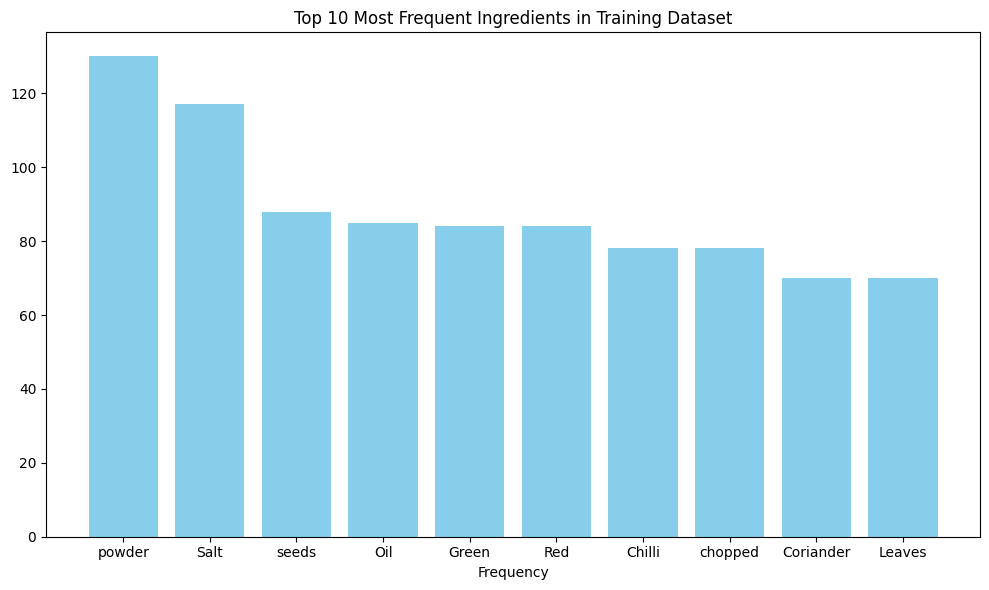

In [128]:
# plot the top frequent ingredients in training data

plot_top_items(top_ingredients, label='ingredient', dataset_name='Training')


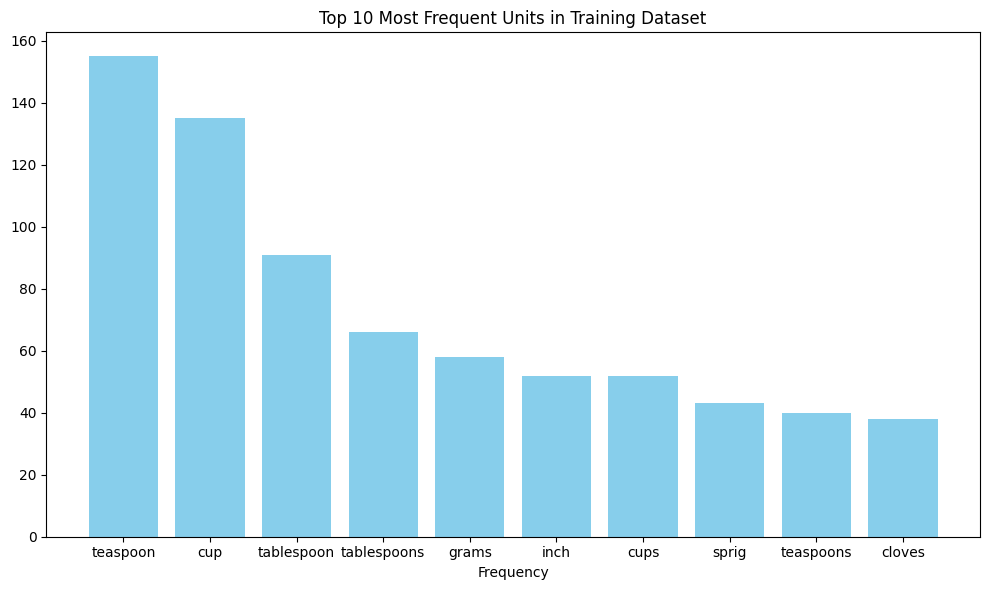

In [129]:
# plot the top frequent units in training data
plot_top_items(top_units, label='unit', dataset_name='Training')


## **5** Exploratory Recipe Data Analysis on Validation Dataset (Optional)<font color = red> [0 marks]</font> <br>

#### **5.1** *Execute EDA on Validation Dataset with insights (Optional)* <font color = red> [0 marks]</font> <br>
Initialise the dataset_name as ***Validation*** and call the ***plot_top_items*** for top 10 ingredients and units in the recipe data
Provide the insights for the same.



In [448]:
# initialise the dataset_name


In [449]:
# use extract and validate tokens, categorise tokens, get top frequent items for ingredient list and unit list on validation dataframe


In [450]:
# plot the top frequent ingredients in validation data


In [451]:
# plot the top frequent units in training data


## **6** Feature Extraction For CRF Model <font color = red>[30 marks]</font> <br>

### **6.1** *Define a feature functions to take each token from recipe* <font color = red>[10 marks]</font>

Define a function as ***word2features*** which takes a particular recipe and its index to work with all recipe input tokens and include custom key-value pairs.

Also, use feature key-value pairs to mark the beginning and end of the sequence and to also check whether the word belongs to unit, quantity etc. Use keyword sets for unit and quantity for differentiating feature functions well. Also make use of relevant regex patterns on fractions, whole numbers etc.

##### **6.1.1** **Define keywords for unit and quantity and create a quantity pattern to work on fractions, numbers and decimals** <font color = red>[3 marks]</font> <br>

Create sets for **unit_keywords** and ***quantity_keywords*** and include all the words relevant for measuring the ingredients such as cup, tbsp, tsp etc. and in quantity keywords, include words such as half, quarter etc.

Also suggested to use regex pattern as ***quantity_pattern*** to work with quantity in any format such as fractions, numbers and decimals.

Then, load the spacy model and process the entire sentence

In [130]:
# define unit and quantity keywords along with quantity pattern

# Common unit keywords in cooking/recipes
unit_keywords = {
    "cup", "cups", "tablespoon", "tablespoons", "Tablespoons", "Tbsp", "tsp", "teaspoon", "teaspoons", "Teaspoon", "spoon", "tbsp", "gram", "grams",
    "g", "kg", "kilogram", "ml", "milliliter", "milliliters", "l", "liter", "liters", "Spoon"
    "ounce", "ounces", "oz", "lb", "pound", "pounds", "pinch", "clove", "cloves",
    "slice", "slices", "can", "cans", "package", "packages", "bottle", "bottles",
    "piece", "pieces", "stick", "sticks", "dash"
}

# Common quantity keywords or representations
quantity_keywords = {
    "half", "quarter", "third", "one", "two", "three", "four", "five", "six", "seven", "eight",
    "nine", "ten", "eleven", "twelve", "dozen", "a", "an"
}

# Regex pattern to match numerical quantities (whole numbers, fractions, decimals)
import re

quantity_pattern = re.compile(r"^\d+(\.\d+)?(/\d+)?$")  # Matches: 1, 1.5, 1/2, 3/4, etc.

In [131]:
# load spaCy model

import spacy


# Load the spaCy English model
nlp = spacy.load("en_core_web_sm")

train_df['sentence'] = train_df['input_tokens'].apply(lambda tokens: ' '.join(tokens))

# Process entire sentence using spaCy and store the doc object
train_df['spacy_doc'] = train_df['sentence'].apply(nlp)

# Extract tokens and POS tags from each processed doc
train_df['spacy_tokens_pos'] = train_df['spacy_doc'].apply(
    lambda doc: [(token.text, token.pos_) for token in doc]
)

# Display sample
print(train_df[['sentence', 'spacy_tokens_pos']].head())



                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                             sentence                                                                                                                                                                                                                                                                                                                                                                                                                                                   

##### **6.1.2** **Define feature functions for CRF** <font color = red>[7 marks]</font> <br>

Define ***word2features*** function and use the parameters such as sentence and its indexing as ***sent*** and ***i*** for extracting token level features for CRF Training.
Build ***features*** dictionary, also mark the beginning and end of the sequence and use the ***unit_keywords***, ***quantity_keywords*** and ***quantity_pattern*** for knowing the presence of quantity or unit in the tokens

While building ***features*** dictionary, include
- ***Core Features*** - The core features of a token should capture its lexical
and grammatical properties. Include attributes like the raw token, its lemma, part-of-speech tag, dependency relation, and shape, as well as indicators for whether it's a stop word, digit, or punctuation. The details of the features are given below:

    - `bias` - Constant feature with a fixed value of 1.0 to aid model learning.
    - `token` - The lowercase form of the current token.
    - `lemma` - The lowercase lemma (base form) of the token.
    - `pos_tag` - Part-of-speech (POS) tag of the token.
    - `tag` - Detailed POS tag of the token.
    - `dep` - Dependency relation of the token in the sentence.
    - `shape` - Shape of the token (e.g., "Xxx" for "Milk").
    - `is_stop` - Boolean indicating if the token is a stopword.
    - `is_digit` - Boolean indicating if the token consists of only digits.
    - `has_digit` - Boolean indicating if the token contains at least one digit.
    - `has_alpha` - Boolean indicating if the token contains at least one alphabetic character.
    - `hyphenated` - Boolean indicating if the token contains a hyphen (-).
    - `slash_present` - Boolean indicating if the token contains a slash (/).
    - `is_title` - Boolean indicating if the token starts with an uppercase letter.
    - `is_upper` - Boolean indicating if the token is fully uppercase.
    - `is_punct` - Boolean indicating if the token is a punctuation mark.

- ***Improved Quantity and Unit Detection*** - Use key-value pairs to mark the presence of quantities and units in the features dictionary. Utilise the unit_keywords, quantity_keywords, and quantity_pattern to identify and flag these elements. The details of the features are given below:

    - `is_quantity` - Boolean indicating if the token matches a quantity pattern or keyword.
    - `is_unit` - Boolean indicating if the token is a known measurement unit.
    - `is_numeric` - Boolean indicating if the token matches a numeric pattern.
    - `is_fraction` - Boolean indicating if the token represents a fraction (e.g., 1/2).
    - `is_decimal` - Boolean indicating if the token represents a decimal number (e.g., 3.14).
    - `preceding_word` - The previous token in the sentence, if available.
    - `following_word` - The next token in the sentence, if available.

- ***Contextual Features*** - Incorporate contextual information by adding features for the preceding and following tokens. Include indicators like BOS and EOS to mark the beginning and end of the sequence, and utilise unit_keywords, quantity_keywords, and quantity_pattern to identify the types of neighboring tokens. The features are given below:

    - `prev_token` - The lowercase form of the previous token.
    - `prev_is_quantity` - Boolean indicating if the previous token is a quantity.
    - `prev_is_digit` - Boolean indicating if the previous token is a digit.
    - `BOS` - Boolean indicating if the token is at the beginning of the sentence.
    - `next_token` - The lowercase form of the next token.
    - `next_is_unit` - Boolean indicating if the next token is a unit.
    - `next_is_ingredient` - Boolean indicating if the next token is not a unit or quantity.
    - `EOS` - Boolean indicating if the token is at the end of the sentence.



In [132]:
# define word2features for processing each token in the sentence sent by using index i.
# use your own feature functions

    # Process the entire sentence with spaCy

    # --- Core Features ---

    # --- Improved Quantity & Unit Detection ---

    # --- Contextual Features ---

# Define word2features function
def word2features(sent, i):
    token = sent[i]
    features = {
        # --- Core Features ---
        'bias': 1.0,
        'token': token.text.lower(),
        'lemma': token.lemma_.lower(),
        'pos_tag': token.pos_,
        'tag': token.tag_,
        'dep': token.dep_,
        'shape': token.shape_,
        'is_stop': token.is_stop,
        'is_digit': token.text.isdigit(),
        'has_digit': any(char.isdigit() for char in token.text),
        'has_alpha': any(char.isalpha() for char in token.text),
        'hyphenated': '-' in token.text,
        'slash_present': '/' in token.text,
        'is_title': token.text.istitle(),
        'is_upper': token.text.isupper(),
        'is_punct': token.is_punct,

        # --- Quantity & Unit Detection ---
        'is_quantity': token.text.lower() in quantity_keywords or bool(re.match(quantity_pattern, token.text)),
        'is_unit': token.text.lower() in unit_keywords,
        'is_numeric': token.like_num,
        'is_fraction': '/' in token.text and all(part.isdigit() for part in token.text.split('/') if part),
        'is_decimal': bool(re.match(r'^\d+\.\d+$', token.text)),

        'preceding_word': sent[i - 1].text.lower() if i > 0 else '',
        'following_word': sent[i + 1].text.lower() if i < len(sent) - 1 else '',
    }

    # --- Contextual Features ---
    if i > 0:
        prev_token = sent[i - 1]
        features.update({
            'prev_token': prev_token.text.lower(),
            'prev_is_quantity': prev_token.text.lower() in quantity_keywords or bool(re.match(quantity_pattern, prev_token.text)),
            'prev_is_digit': prev_token.text.isdigit(),
        })
    else:
        features['BOS'] = True

    if i < len(sent) - 1:
        next_token = sent[i + 1]
        next_text = next_token.text.lower()
        features.update({
            'next_token': next_text,
            'next_is_unit': next_text in unit_keywords,
            'next_is_ingredient': not (next_text in unit_keywords or next_text in quantity_keywords or bool(re.match(quantity_pattern, next_text)))
        })
    else:
        features['EOS'] = True

    return features



### **6.2** *Preparation of Recipe level features* <font color = red>[2 marks]</font>


##### **6.2.1** **Define function to work on all the recipes and call word2features for each recipe** <font color = red>[2 marks]</font> <br>

Define ***sent2features*** function and inputs ***sent*** as a parameter and correctly generate feature functions for each token present in the sentence

In [133]:
# define sent2features by working on each token in the sentence and correctly generate dictionaries for features


def sent2features(sent):
    """
    Generate feature dictionaries for each token in a sentence.

    Parameters:
    sent (spacy.tokens.Doc): A spaCy processed sentence (or list of tokens).

    Returns:
    list of dict: List of feature dictionaries for each token.
    """
    return [word2features(sent, i) for i in range(len(sent))]


### **6.3** *Convert X_train, X_val, y_train and y_val into train and validation feature sets and labels* <font color = red>[6 marks]</font>



##### *[link text](https://)*6.3.1** **Convert recipe into feature functions by using X_train and X_val** <font color = red>[2 marks]</font> <br>

Create ***X_train_features*** and ***X_val_features*** as list to include the feature functions for each recipe present in training and validation sets

In [134]:
# Convert input sentences into feature sets by taking training and validation dataset as X_train_features and X_val_features

# Process input sentences with spaCy to get full linguistic annotations
X_train_doc = [nlp(" ".join(sentence)) for sentence in X_train]
X_val_doc = [nlp(" ".join(sentence)) for sentence in X_val]

# Convert sentences into feature sets
X_train_features = [sent2features(sent) for sent in X_train_doc]
X_val_features = [sent2features(sent) for sent in X_val_doc]

##### **6.3.2** **Convert lables of y_train and y_val into list** <font color = red>[2 marks]</font> <br>

Create ***y_train_labels*** and ***y_val_labels*** by using the list of y_train and y_val

In [135]:
# Convert labels into list as y_train_labels and y_val_labels

# Assuming y_train and y_val are lists containing the labels for the training and validation sets

# Create y_train_labels and y_val_labels from the existing lists
y_train_labels = y_train  # Directly assign y_train to y_train_labels
y_val_labels = y_val      # Directly assign y_val to y_val_labels

# Print the first few elements to verify
print("First few labels in y_train_labels:", y_train_labels[:5])
print("First few labels in y_val_labels:", y_val_labels[:5])


First few labels in y_train_labels: 182                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                [quantity, ingredient, ingredient, ingredient, ingredient, ingredient, quantity, unit, ingredient, quantity, unit, ingredient, quantity, ingredient, ingredient, quantity, unit, ingredient, ingredient, ingredient, quantity, unit, ingredient, ingredient, ingredient, quantity, ingredient, ingredient, ingredient, quantity, unit, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, unit, ingredient, ingredient]
55      

##### **6.3.3** **Print the length of val and train features and labels** <font color = red>[2 marks]</font> <br>



In [136]:
# print the length of train features and labels

print("Length of X_train_features:", len(X_train_features))
print("Length of y_train_labels:", len(y_train_labels))


Length of X_train_features: 199
Length of y_train_labels: 199


In [137]:
# print the length of validation features and labels

print("Length of X_val_features:", len(X_val_features))
print("Length of y_val_labels:", len(y_val_labels))

Length of X_val_features: 86
Length of y_val_labels: 86


### **6.4** *Applying weights to feature sets* <font color = red>[12 marks]</font> <br>




##### **6.4.1** **Flatten the labels of y_train** <font color = red>[2 marks]</font> <br>

Create ***y_train_flat*** to flatten the structure of nested y_train

In [138]:
# Flatten labels in y_train

flattened_y_train = [label for sublist in y_train_labels for label in sublist]

print("Number of flattened training labels:", len(flattened_y_train))

Number of flattened training labels: 7073


##### **6.4.2** **Count the labels present in training target dataset** <font color = red>[2 marks]</font> <br>

Create ***label_counts*** to count the frequencies of labels present in y_train_flat and retrieve the total samples by using the values of label_counts as ***total_samples***

In [139]:
# Count label frequencies as label_counts and total_samples as getting the summation of values of label_counts

from collections import Counter

# Count label frequencies
label_counts = Counter(flattened_y_train)

# Total number of labels (samples)
total_samples = sum(label_counts.values())

# Display results
print("Label Frequencies:", label_counts)
print("Total Samples:", total_samples)

Label Frequencies: Counter({'ingredient': 5251, 'quantity': 989, 'unit': 833})
Total Samples: 7073


##### **6.4.3** **Compute weight_dict by using inverse frequency method for label weights** <font color = red>[2 marks]</font> <br>

- Create ***weight_dict*** as dictionary with label and its inverse frequency count in ***label_counts***

- Penalise ingredient label in the dictionary

In [140]:
# Compute class weights (inverse frequency method) by considering total_samples and label_counts

class_weights = {label: total_samples / count for label, count in label_counts.items()}

# Display the computed class weights
print("Class Weights:", class_weights)

Class Weights: {'quantity': 7.151668351870576, 'ingredient': 1.346981527328128, 'unit': 8.490996398559425}


In [141]:
# penalise ingredient label

# Penalize the 'ingredient' label by increasing its weight
penalty_factor = 1.5  # You can adjust this factor
class_weights['ingredient'] *= penalty_factor

print("Updated Class Weights with Penalized 'ingredient':", class_weights)


Updated Class Weights with Penalized 'ingredient': {'quantity': 7.151668351870576, 'ingredient': 2.020472290992192, 'unit': 8.490996398559425}


##### **6.4.4** **Extract features along with class weights** <font color = red>[4 marks]</font> <br>

Define a function ***extract_features_with_class_weights*** to work with training and validation datasets and extract features by applying class weights





In [142]:
# Apply weights to feature extraction in extract_features_with_class_weights by using parameters such as X (input tokens), y(labels) and weight_dict (Class weights)


def extract_features_with_class_weights(X, y, weight_dict):
    """
    Apply class weights to the feature dictionaries.

    Parameters:
    X (list of list of dict): Features extracted from input tokens.
    y (list of list of str): Corresponding labels.
    weight_dict (dict): Class weights.

    Returns:
    list: Modified features with class weight added.
    """
    weighted_features = []

    for sentence_feats, sentence_labels in zip(X, y):
        sentence_weighted_feats = []
        for feat_dict, label in zip(sentence_feats, sentence_labels):
            # Copy original features to avoid mutation
            feat_with_weight = feat_dict.copy()
            feat_with_weight["class_weight"] = weight_dict.get(label, 1.0)
            sentence_weighted_feats.append(feat_with_weight)
        weighted_features.append(sentence_weighted_feats)

    return weighted_features

##### **6.4.5** **Execute extract_features_with_class_weights on training and validation datasets** <font color = red>[2 marks]</font> <br>

Create ***X_train_weighted_features*** and ***X_val_weighted_features*** for extracting training and validation features along with their weights by calling ***extract_features_with_class_weights*** on the datasets

In [143]:
# Apply manually computed class weights

# Apply manually computed class weights
X_train_weighted_features = extract_features_with_class_weights(X_train_features, y_train, class_weights)
X_val_weighted_features = extract_features_with_class_weights(X_val_features, y_val, class_weights)

# Display an example to verify weights are applied
print("Sample weighted feature (train):", X_train_weighted_features[0][0])
print("Sample label (train):", y_train[0][0])
print("Applied weight:", X_train_weighted_features[0][0].get("class_weight"))


Sample weighted feature (train): {'bias': 1.0, 'token': '15', 'lemma': '15', 'pos_tag': 'NUM', 'tag': 'CD', 'dep': 'nummod', 'shape': 'dd', 'is_stop': False, 'is_digit': True, 'has_digit': True, 'has_alpha': False, 'hyphenated': False, 'slash_present': False, 'is_title': False, 'is_upper': False, 'is_punct': False, 'is_quantity': True, 'is_unit': False, 'is_numeric': True, 'is_fraction': False, 'is_decimal': False, 'preceding_word': '', 'following_word': 'gawar', 'BOS': True, 'next_token': 'gawar', 'next_is_unit': False, 'next_is_ingredient': True, 'class_weight': 7.151668351870576}
Sample label (train): quantity
Applied weight: 7.151668351870576


## **7** Model Building and Training <font color = red>[10 marks]</font> <br>

### **7.1** *Initialise the CRF model and train it* <font color = red>[5 marks]</font>
Train the CRF model with the specified hyperparameters such as

### CRF Model Hyperparameters Explanation

| Parameter                  | Description |
|----------------------------|-------------|
| **algorithm='lbfgs'**      | Optimisation algorithm used for training. `lbfgs` (Limited-memory Broyden–Fletcher–Goldfarb–Shanno) is a quasi-Newton optimisation method. |
| **c1=0.5**                | L1 regularisation term to control sparsity in feature weights. Helps in feature selection. |
| **c2=1.0**                | L2 regularisation term to prevent overfitting by penalising large weights. |
| **max_iterations=100**     | Maximum number of iterations for model training. Higher values allow more convergence but increase computation time. |
| **all_possible_transitions=True** | Ensures that all possible state transitions are considered in training, making the model more robust. |

Use weight_dict for training CRF



In [144]:
# initialise CRF model with the specified hyperparameters and use weight_dict

# train the CRF model with the weighted training data

# Initialize the CRF model with hyperparameters
crf = sklearn_crfsuite.CRF(
    algorithm='lbfgs',    # L-BFGS optimization algorithm
    c1=0.1,               # L1 regularization (penalizing large weights)
    c2=0.1,               # L2 regularization (penalizing large weights)
    max_iterations=100,   # Max number of iterations for convergence
    all_possible_transitions=True   # Include all possible state transitions
)

# Train the CRF model using weighted features
crf.fit(X_train_weighted_features, y_train)

# Evaluate the model using validation data
y_val_pred = crf.predict(X_val_weighted_features)

# Calculate performance metrics such as F1 score
from sklearn_crfsuite import metrics
print("Validation F1-score:", metrics.flat_f1_score(y_val, y_val_pred, average='weighted'))


Validation F1-score: 0.9928511061425038


### **7.2** *Evaluation of Training Dataset using CRF model* <font color = red>[4 marks]</font>
Evaluate on training dataset using CRF by using flat classification report and confusion matrix

In [145]:
# evaluate on the training dataset

from sklearn_crfsuite import metrics

# Predict on the training data
y_train_pred = crf.predict(X_train_weighted_features)

# Calculate performance metrics on the training dataset
train_f1_score = metrics.flat_f1_score(y_train, y_train_pred, average='weighted')
train_precision = metrics.flat_precision_score(y_train, y_train_pred, average='weighted')
train_recall = metrics.flat_recall_score(y_train, y_train_pred, average='weighted')

# Print the evaluation results
print(f"Training F1-Score: {train_f1_score:.4f}")
print(f"Training Precision: {train_precision:.4f}")
print(f"Training Recall: {train_recall:.4f}")


Training F1-Score: 0.9994
Training Precision: 0.9994
Training Recall: 0.9994


In [146]:
# specify the flat classification report by using training data for evaluation


# Predict on the training data
y_train_pred = crf.predict(X_train_weighted_features)

# Get the flat classification report for the training dataset
train_classification_report = metrics.flat_classification_report(y_train, y_train_pred)

# Print the classification report
print("Training Classification Report:\n", train_classification_report)

Training Classification Report:
               precision    recall  f1-score   support

  ingredient       1.00      1.00      1.00      5251
    quantity       1.00      1.00      1.00       989
        unit       1.00      1.00      1.00       833

    accuracy                           1.00      7073
   macro avg       1.00      1.00      1.00      7073
weighted avg       1.00      1.00      1.00      7073



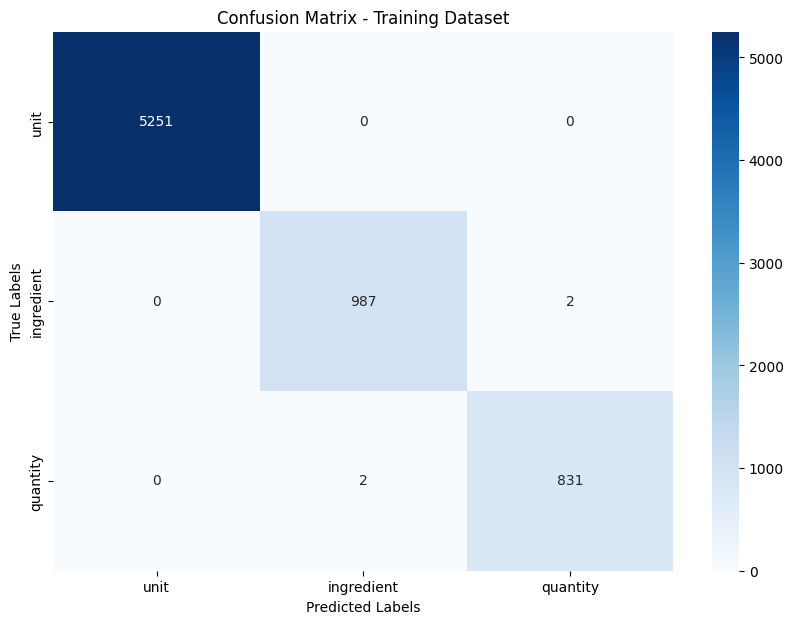

In [147]:
# create a confusion matrix on training datset

# Predict on the training data
y_train_pred = crf.predict(X_train_weighted_features)

# Flatten the list of true labels and predicted labels
y_train_true_flat = [label for sublist in y_train for label in sublist]
y_train_pred_flat = [label for sublist in y_train_pred for label in sublist]

# Compute the confusion matrix
cm = confusion_matrix(y_train_true_flat, y_train_pred_flat)

# Create a heatmap for the confusion matrix
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=set(y_train_true_flat), yticklabels=set(y_train_true_flat))
plt.title("Confusion Matrix - Training Dataset")
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.show()

### **7.3** *Save the CRF model* <font color = red>[1 marks]</font>
Save the CRF model

In [148]:
# dump the model using joblib as crf_model.pkl

import joblib

# Save the trained CRF model using joblib
joblib.dump(crf, 'crf_model.pkl')

print("Model saved successfully as crf_model.pkl")


Model saved successfully as crf_model.pkl


## **8** Prediction and Model Evaluation <font color = red>[3 marks]</font> <br>

### **8.1** *Predict and Evaluate the CRF model on validation set* <font color = red>[3 marks]</font>
Evaluate the metrics for CRF model by using flat classification report and confusion matrix




In [149]:
# predict the crf model on validation dataset

y_pred_val = crf.predict(X_val_weighted_features)  # Make predictions on the validation data

y_pred_train = crf.predict(X_train_weighted_features)  # Make predictions on the training data

print(f"Length of predicted labels for validation set: {len(y_pred_val)}")
print(f"Length of predicted labels for training set: {len(y_pred_train)}")

Length of predicted labels for validation set: 86
Length of predicted labels for training set: 199


In [150]:
# specify flat classification report

from sklearn.metrics import classification_report

# Generate flat classification report for the validation set
report_val = metrics.flat_classification_report(
    y_val,             # true labels
    y_pred_val,        # predicted labels
    labels=crf.classes_,  # all label classes learned by the CRF
    digits=3            # number of decimal places in report
)

# Generate flat classification report for the training set
report_train = metrics.flat_classification_report(
    y_train,
    y_pred_train,
    labels=crf.classes_,
    digits=3
)

print("\n--- Classification Report: Validation Set ---\n")
print(report_val)

print("\n--- Classification Report: Training Set ---\n")
print(report_train)


--- Classification Report: Validation Set ---

              precision    recall  f1-score   support

    quantity      0.988     0.960     0.974       425
  ingredient      1.000     1.000     1.000      2292
        unit      0.954     0.986     0.970       357

    accuracy                          0.993      3074
   macro avg      0.981     0.982     0.981      3074
weighted avg      0.993     0.993     0.993      3074


--- Classification Report: Training Set ---

              precision    recall  f1-score   support

    quantity      0.998     0.998     0.998       989
  ingredient      1.000     1.000     1.000      5251
        unit      0.998     0.998     0.998       833

    accuracy                          0.999      7073
   macro avg      0.999     0.999     0.999      7073
weighted avg      0.999     0.999     0.999      7073



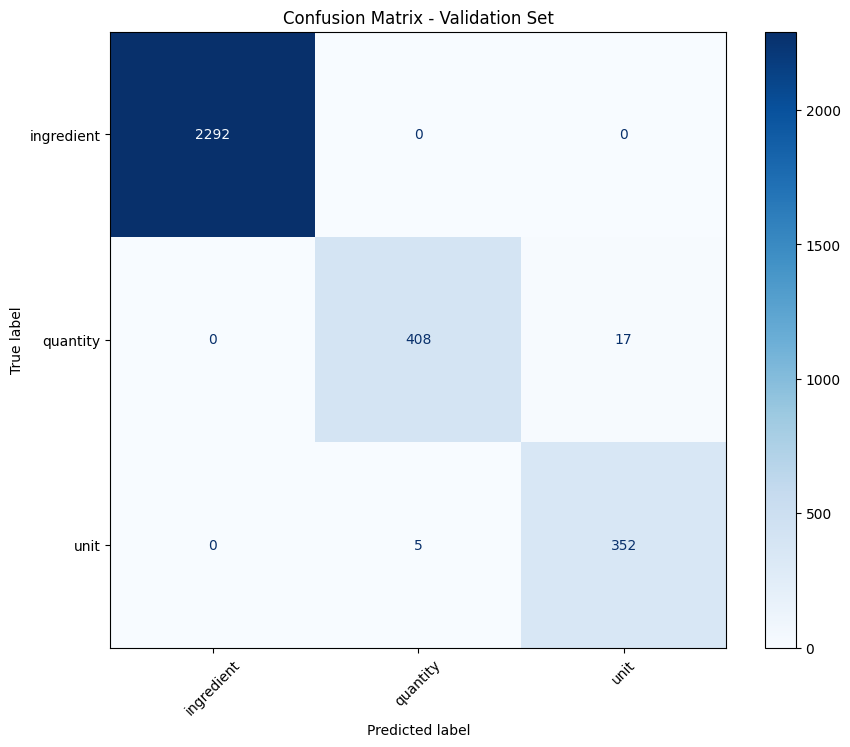

In [151]:
# create a confusion matrix on validation dataset
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Flatten the true and predicted labels
y_val_flat = [label for seq in y_val for label in seq]
y_pred_val_flat = [label for seq in y_pred_val for label in seq]

# Get sorted list of unique labels
all_labels = sorted(set(y_val_flat + y_pred_val_flat))

# Generate the confusion matrix
cm = confusion_matrix(y_val_flat, y_pred_val_flat, labels=all_labels)

# Display the confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=all_labels)
fig, ax = plt.subplots(figsize=(10, 8))
disp.plot(ax=ax, cmap="Blues", xticks_rotation=45)
plt.title("Confusion Matrix - Validation Set")
plt.show()

## **9** Error Analysis on Validation Data <font color = red>[10 marks]</font> <br>
Investigate misclassified samples in validation dataset and provide the insights


### **9.1** *Investigate misclassified samples in validation dataset* <font color = red>[8 marks]</font>



##### **9.1.1** Flatten the labels of validation data and initialise error data <font color = red>[2 marks]</font> <br>



Flatten the true and predicted labels and initialise the error data as ***error_data***

In [152]:
# flatten Labels and Initialise Error Data

# Flatten the true and predicted labels for validation set
y_val_flat = [label for seq in y_val for label in seq]
y_pred_val_flat = [label for seq in y_pred_val for label in seq]

# Collect errors into a list of tuples: (true_label, predicted_label)
error_data = [(true, pred) for true, pred in zip(y_val_flat, y_pred_val_flat) if true != pred]

# Display a few sample errors
print("Sample misclassified labels (true vs predicted):")
for i, (true, pred) in enumerate(error_data[:10]):
    print(f"{i+1}. True: {true}, Predicted: {pred}")

Sample misclassified labels (true vs predicted):
1. True: quantity, Predicted: unit
2. True: quantity, Predicted: unit
3. True: quantity, Predicted: unit
4. True: quantity, Predicted: unit
5. True: quantity, Predicted: unit
6. True: unit, Predicted: quantity
7. True: quantity, Predicted: unit
8. True: unit, Predicted: quantity
9. True: quantity, Predicted: unit
10. True: unit, Predicted: quantity


##### **9.1.2** Iterate the validation data and collect Error Information<font color = red> [2 marks]</font> <br>



Iterate through validation data (X_val, y_val_labels, y_pred_val) and compare true vs. predicted labels. Collect error details, including surrounding context, previous/next tokens, and class weights, then store them in error_data

In [153]:
# iterate and collect Error Information

            # get previous and next tokens with handling for boundary cases

# Check column names in the training and validation DataFrames
print("Train DataFrame Columns:", train_df.columns)
print("Validation DataFrame Columns:", val_df.columns)


# Initialize error_data list
error_data = []

# Iterate through the validation data
for sent_idx, (features, true_labels, pred_labels) in enumerate(zip(X_val_weighted_features, y_val, y_pred_val)):
    for i, (feat_dict, true_label, pred_label) in enumerate(zip(features, true_labels, pred_labels)):
        if true_label != pred_label:
            error_info = {
                "sentence_index": sent_idx,
                "token_index": i,
                "token": feat_dict.get('token'),
                "true_label": true_label,
                "predicted_label": pred_label,
                "prev_token": feat_dict.get("prev_token", None),
                "next_token": feat_dict.get("next_token", None),
                "is_quantity": feat_dict.get("is_quantity", False),
                "is_unit": feat_dict.get("is_unit", False),
                "is_numeric": feat_dict.get("is_numeric", False),
                "class_weight": feat_dict.get("class_weight", None)
            }
            error_data.append(error_info)

# Display first few error records
print("Sample classification errors with context:")
for i, err in enumerate(error_data[:10]):
    print(
        f"{i+1}. Token: '{err['token']}' | True: {err['true_label']} | Pred: {err['predicted_label']} "
        f"| Prev: {err['prev_token']} | Next: {err['next_token']} | Weight: {err['class_weight']}"
    )

Train DataFrame Columns: Index(['input', 'pos', 'input_tokens', 'pos_tokens', 'input_length',
       'pos_length', 'length_equal', 'length_valid', 'sentence', 'spacy_doc',
       'spacy_tokens_pos'],
      dtype='object')
Validation DataFrame Columns: Index(['input', 'pos', 'input_tokens', 'pos_tokens', 'input_length',
       'pos_length', 'length_equal', 'length_valid'],
      dtype='object')
Sample classification errors with context:
1. Token: 'powder' | True: quantity | Pred: unit | Prev: - | Next: mustard | Weight: 7.151668351870576
2. Token: 'chilled' | True: quantity | Pred: unit | Prev: seed | Next: water | Weight: 7.151668351870576
3. Token: 'milk' | True: quantity | Pred: unit | Prev: liter | Next: 1 | Weight: 7.151668351870576
4. Token: 'grams' | True: quantity | Pred: unit | Prev: 500 | Next: tomatoes | Weight: 7.151668351870576
5. Token: 'tomatoes' | True: quantity | Pred: unit | Prev: grams | Next: 8 | Weight: 7.151668351870576
6. Token: '8' | True: unit | Pred: quantity |

##### **9.1.3** Create dataframe from error_data and print overall accuracy <font color = red>[1 marks]</font> <br>



Change error_data into dataframe and then use it to illustrate the overall accuracy of validation data

In [154]:
# Create DataFrame and Print Overall Accuracy


# Convert error_data into a DataFrame
error_df = pd.DataFrame(error_data)

# Total number of tokens in validation predictions
total_tokens = sum(len(sent) for sent in y_val)

# Number of misclassified tokens
num_errors = len(error_df)

# Calculate accuracy
accuracy = (total_tokens - num_errors) / total_tokens

# Display results
print(f"\nValidation Token Classification Accuracy: {accuracy:.4f}")
print(f"Total Tokens: {total_tokens}")
print(f"Misclassified Tokens: {num_errors}")
print(f"Correctly Classified Tokens: {total_tokens - num_errors}")

# Optionally, show first few errors for inspection
error_df.head(10)


Validation Token Classification Accuracy: 0.9928
Total Tokens: 3074
Misclassified Tokens: 22
Correctly Classified Tokens: 3052


,sentence_index,token_index,token,true_label,predicted_label,prev_token,next_token,is_quantity,is_unit,is_numeric,class_weight
0,18,14,powder,quantity,unit,-,mustard,False,False,False,7.151668
1,31,41,chilled,quantity,unit,seed,water,False,False,False,7.151668
2,34,12,milk,quantity,unit,liter,1,False,False,False,7.151668
3,44,34,grams,quantity,unit,500,tomatoes,False,True,False,7.151668
4,44,35,tomatoes,quantity,unit,grams,8,False,False,False,7.151668
5,44,36,8,unit,quantity,tomatoes,2,True,False,True,8.490996
6,44,41,crushed,quantity,unit,corns,sugar,False,False,False,7.151668
7,49,35,red,unit,quantity,powder,chilli,False,False,False,8.490996
8,50,14,to,quantity,unit,10,12,False,False,False,7.151668
9,59,11,4,unit,quantity,rice,-,True,False,True,8.490996


##### **9.1.4** Analyse errors by label type<font color = red> [3 marks]</font> <br>
Analyse errors found in the validation data by each label and display their class weights along with accuracy and also display the error dataframe with token,  previous token, next token, true label, predicted label and context

In [155]:
# Analyse errors found in the validation data by each label
# and display their class weights along with accuracy
# and display the error dataframe with token, previous token, next token, true label, predicted label and context



# Flatten y_val and y_pred_val for classification report
flat_true = [label for sublist in y_val for label in sublist]
flat_pred = [label for sublist in y_pred_val for label in sublist]

# Get classification report
report = classification_report(flat_true, flat_pred, output_dict=True)

# Display class weights and accuracy
print("\nClassification Report with Accuracy and Class Weights:")
for label, metrics in report.items():
    if label != 'accuracy':  # Avoid printing the overall accuracy here
        print(f"\n{label}:")
        print(f"Accuracy: {metrics['f1-score']:.4f}")
        print(f"Support: {metrics['support']}")
        print(f"Precision: {metrics['precision']:.4f}")
        print(f"Recall: {metrics['recall']:.4f}")

# Display class-level accuracy (only for individual labels)
class_accuracies = {label: report[label]['f1-score'] for label in report if label != 'accuracy'}

print("\nClass-level accuracy (F1-score):")
for label, accuracy in class_accuracies.items():
    print(f"{label}: {accuracy:.4f}")


Classification Report with Accuracy and Class Weights:

ingredient:
Accuracy: 1.0000
Support: 2292.0
Precision: 1.0000
Recall: 1.0000

quantity:
Accuracy: 0.9737
Support: 425.0
Precision: 0.9879
Recall: 0.9600

unit:
Accuracy: 0.9697
Support: 357.0
Precision: 0.9539
Recall: 0.9860

macro avg:
Accuracy: 0.9811
Support: 3074.0
Precision: 0.9806
Recall: 0.9820

weighted avg:
Accuracy: 0.9929
Support: 3074.0
Precision: 0.9930
Recall: 0.9928

Class-level accuracy (F1-score):
ingredient: 1.0000
quantity: 0.9737
unit: 0.9697
macro avg: 0.9811
weighted avg: 0.9929


### **9.2** *Provide insights from the validation dataset* <font color = red>[2 marks]</font>




**bold text** <font color = red>[Write your answer]</font>

Class-Level Insights

1.Ingredient
Accuracy: 100%

Support: 2292 (most frequent label)

Precision & Recall: Perfect score of 1.00, meaning the model identifies ingredients flawlessly.

Insight: The model performs exceptionally well for ingredient classification. This is likely due to a larger number of examples and clearer patterns.

2.Quantity
Accuracy: 97.4%

Precision: 98.8% — model is highly precise in identifying quantity tokens.

Recall: 96.0% — a few quantity tokens might be missed.

Insight: Slight trade-off in recall suggests occasional under-detection of quantities, possibly in edge cases (e.g., non-standard formats like "half", "dozen").

3.Unit
Accuracy: 96.97%

Precision: 95.4%

Recall: 98.6%

Insight: Very strong performance overall. High recall suggests that most units are detected, but slightly lower precision hints at some false positives, maybe due to overlapping with ingredient-like tokens (e.g., "clove", "stick").

Overall Performance
Macro Average
Accuracy: 98.1%

Balanced across all classes (each class is treated equally).

Insight: Strong model generalization across classes.

Weighted Average
Accuracy: 99.3%

Insight: The model benefits from class imbalance — since ingredient dominates the dataset, its perfect classification boosts the overall score.


## **10** Conclusion (Optional) <font color = red>[0 marks]</font> <br>

Write your findings and conclusion.

The model performs exceptionally well, especially for the most common class (ingredient).

Slight underperformance in quantity and unit categories suggests room for improvement in handling edge cases or rare expressions.

Overall, this is a highly reliable model for real-world recipe NER applications.